<a href="https://colab.research.google.com/github/Maratinhos/hw/blob/master/Kaggle_Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
%matplotlib inline

In [6]:
file = files.upload()

Saving kaggle.json to kaggle.json


In [7]:
!ls

drive  kaggle.json  sample_data  test.csv  train.csv


In [0]:
!mkdir ~/.kaggle

In [0]:
!mv kaggle.json ~/.kaggle

In [10]:
!kaggle competitions download -c digit-recognizer

 68% 50.0M/73.2M [00:01<00:00, 26.0MB/s]
100% 73.2M/73.2M [00:01<00:00, 50.6MB/s]
 82% 40.0M/48.8M [00:01<00:00, 12.4MB/s]
100% 48.8M/48.8M [00:02<00:00, 23.0MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 106MB/s]


In [0]:
train_dataset = np.loadtxt('train.csv', skiprows=1, delimiter=',')

In [0]:
test_dataset = np.loadtxt('test.csv', skiprows = 1, delimiter = ',')

In [15]:
(train_dataset.shape, test_dataset.shape)

((42000, 785), (28000, 784))

In [0]:
x_train = train_dataset[:, 1:]
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = test_dataset.reshape(test_dataset.shape[0], 28, 28, 1)

In [0]:
x_train /= 255.0
x_test /= 255.0

In [0]:
y_train = train_dataset[:, 0]

In [0]:
y_train = utils.to_categorical(y_train)

In [20]:
(x_train.shape, y_train.shape)

((42000, 28, 28, 1), (42000, 10))

In [0]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = random_seed)

In [65]:
(X_train.shape, X_val.shape)

((33600, 28, 28, 1), (8400, 28, 28, 1))

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

In [0]:
val_datagen = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

In [0]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
#model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 192, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
#model.add(Dropout(0.25))

model.add(Conv2D(filters = 192, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2, padding='same'))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#print(model.summary())

In [0]:
checkpoint = ModelCheckpoint('kaggle-digit-rec.hdf5', monitor = 'val_acc', save_best_only = True, verbose = 1, mode = 'max')

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.3, min_lr = 0.00001)

In [0]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 1e-10, patience = 10, verbose = 1, restore_best_weights = True)

In [0]:
batch_size = 100

In [0]:
history = model.fit(#train_datagen.flow(X_train, Y_train, batch_size = batch_size),
                   X_train, 
                   Y_train,
                   batch_size = batch_size,
                   epochs = 50,
                   validation_data = (X_val, Y_val),
                   #validation_data = val_datagen.flow(X_val, Y_val, batch_size = batch_size),
                   #steps_per_epoch = X_train.shape[0] // batch_size,
                   verbose = 1,
                   callbacks = [checkpoint, learning_rate_reduction, early_stopping],
                   shuffle = True)

Train on 33600 samples, validate on 8400 samples
Epoch 1/50
33500/33600 [============================>.] - ETA: 0s - loss: 0.1883 - acc: 0.9396

In [0]:
model.load_weights('kaggle-digit-rec.hdf5')

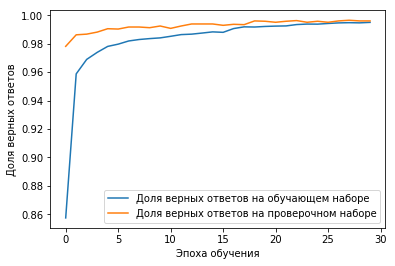

In [0]:
plt.plot(history.history['acc'], label = 'Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], label = 'Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [0]:
predictions = model.predict(x_test)

In [0]:
predictions = np.argmax(predictions, axis = 1)

In [0]:
out = np.column_stack((range(1, predictions.shape[0] + 1), predictions))

In [0]:
np.savetxt('submission.csv', out, header = 'ImageId,Label', comments = '', fmt = '%d,%d')

In [0]:
!kaggle competitions submit -c digit-recognizer -m 'My submission #2' -f submission.csv